<a href="https://colab.research.google.com/github/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/blob/main/Company_Bankruptcy_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest Data

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

In [30]:
df.columns = df.columns.str.strip()

### EDA

In [31]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

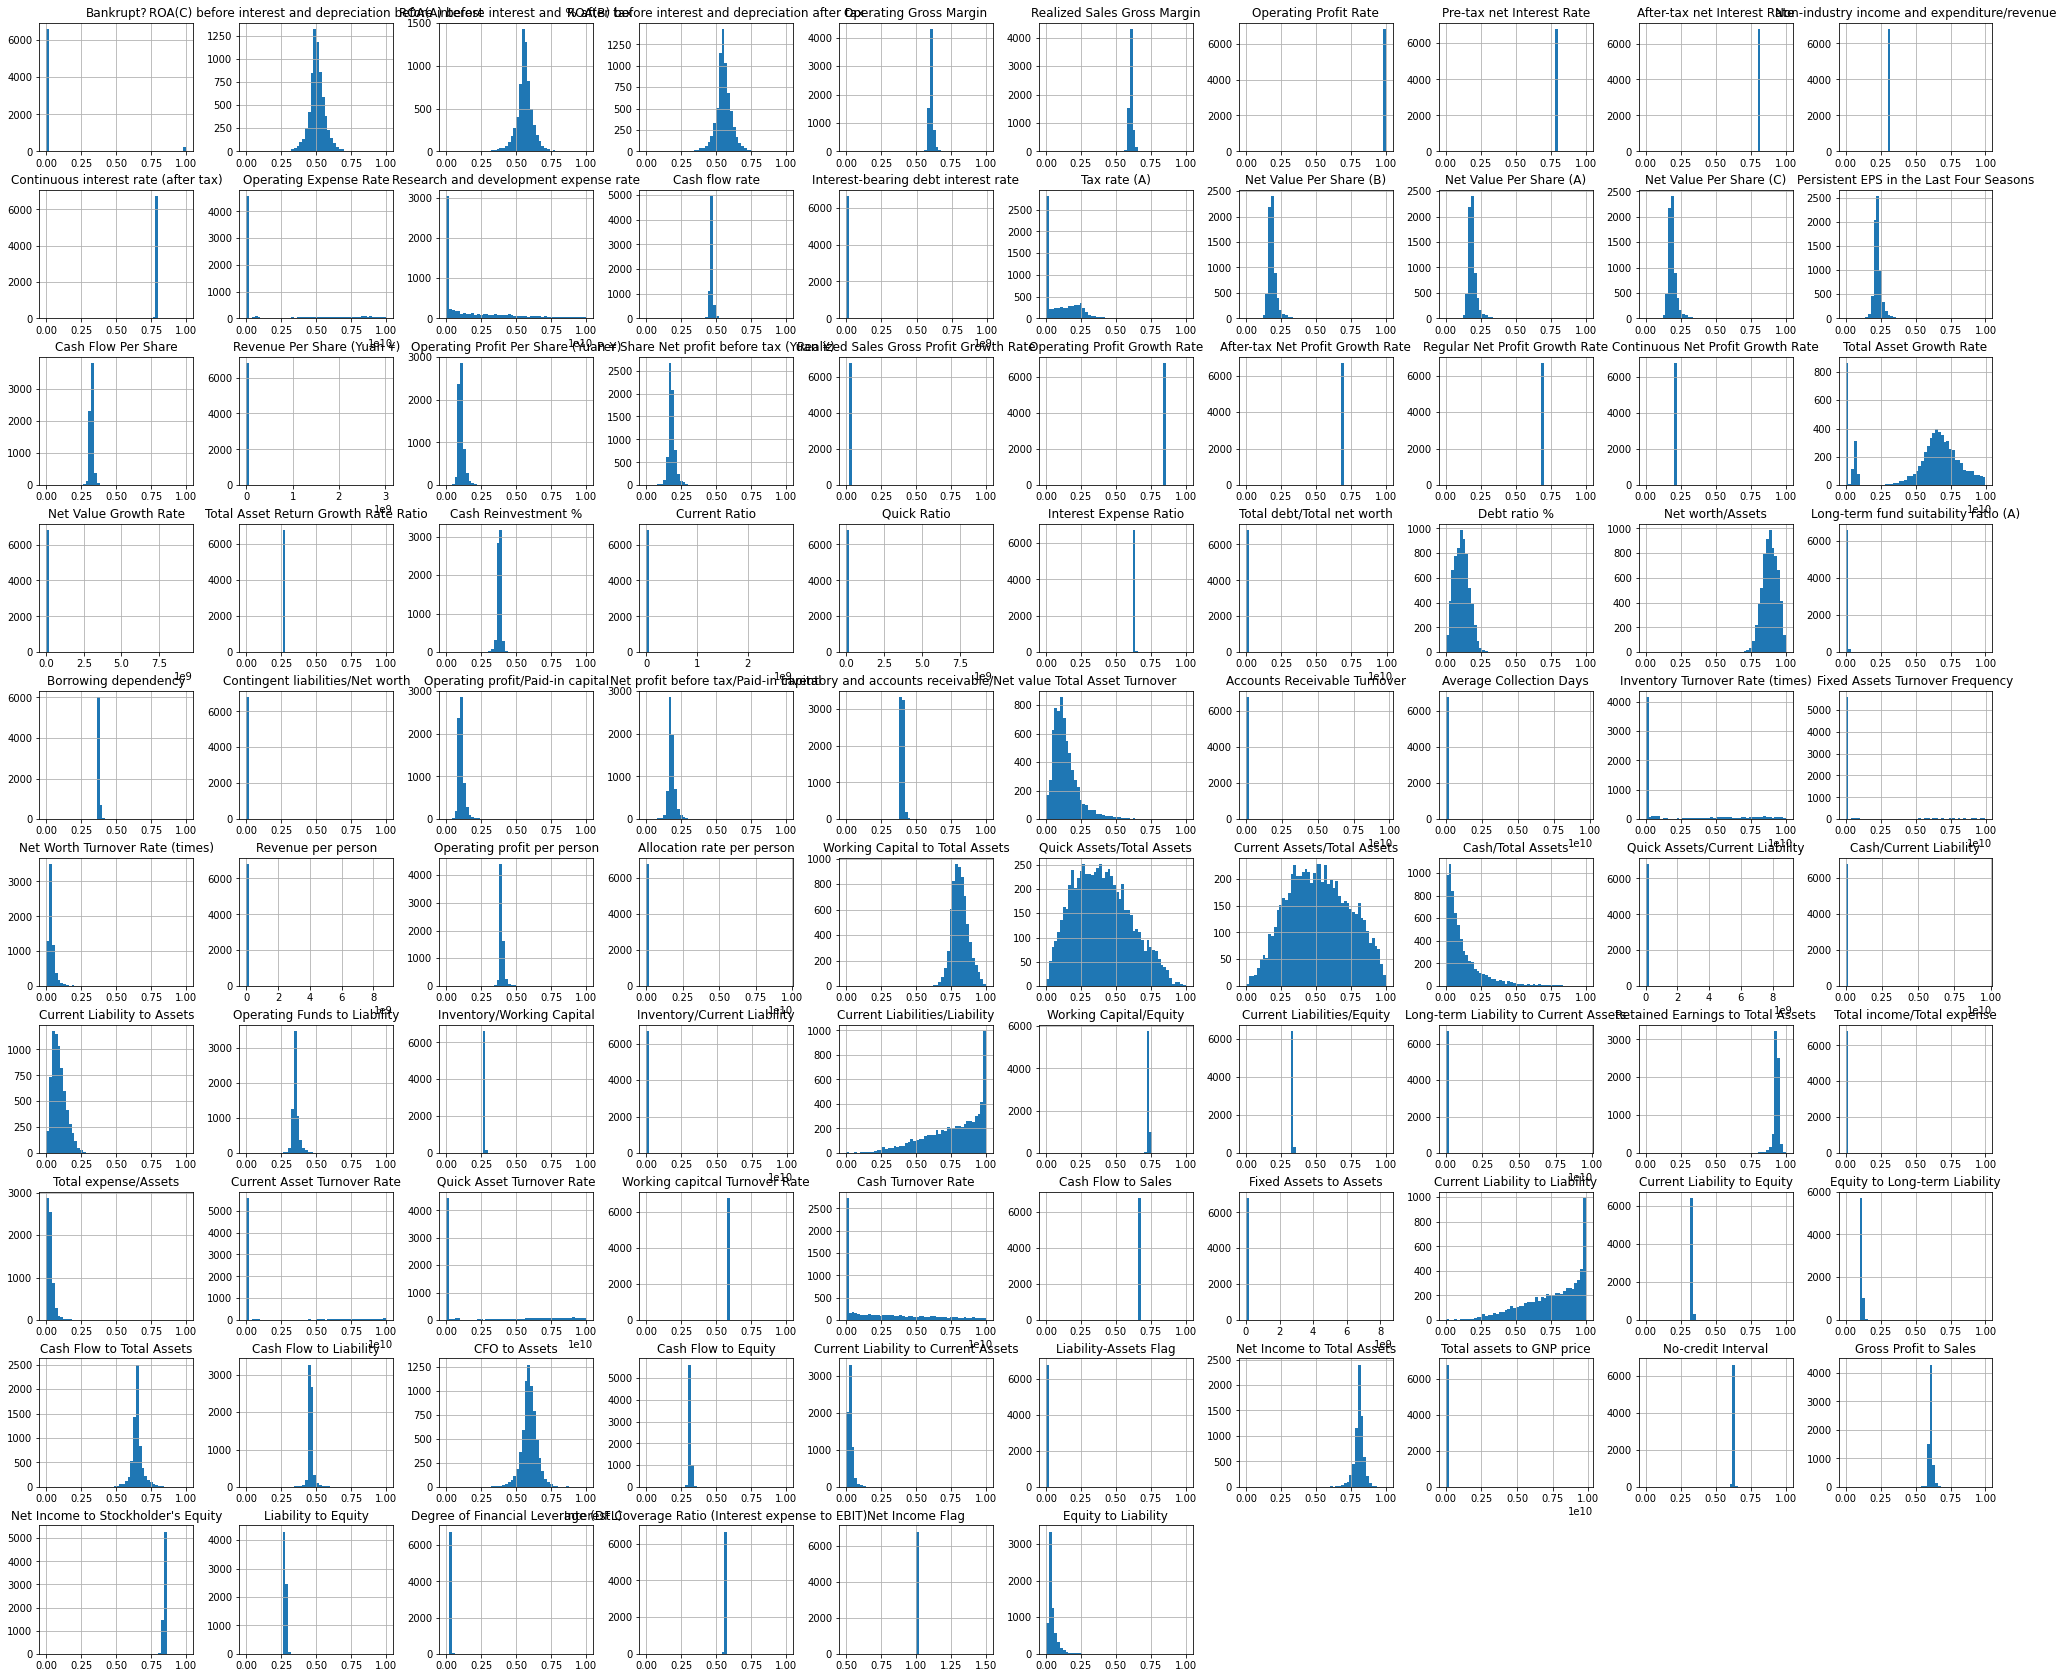

In [32]:
df.hist(figsize = (35,30), bins = 50)
plt.show()

Assesing the histograms, we can see that hardly any of the columns are normalized so we are going to impliment different scaling techniques in order to deal with the possible outliers in this dataset.

In [33]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
robust_data = robust.fit_transform(df)
df_robust = pd.DataFrame(robust_data)

RobustScaler from scikit-learn has two main parameters to focus on: with_centering - if this is True, it will center the data before scaling it, with_scaling (median is subtracted) - if this is True, it will scale the data to the IQR (std is set to 1). The quantile_range parameter can be specified to calculate the scale based on some other range than the IQR of that column. 

In [34]:
df_robust.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.041907,-0.021947,0.023065,0.144812,0.145701,-2.131590,-1.419065,-1.849476,0.819326,-1.504045,4.813866e-01,0.417805,0.248933,4.991311e+10,0.201668,0.241179,0.240123,0.241829,0.177073,0.091472,4.324181e+07,0.242367,0.201158,3.447260,-0.458987,-0.775136,-0.765888,0.975638,-0.352531,2.682180e+10,0.314525,-0.062490,4.627756e+07,1.113435e+09,0.570757,7.047822e+08,0.023321,-0.023321,1.944256,...,0.022140,0.385847,4.659369e+08,3.430396e+09,0.120323,0.262989,0.550766,6.990164e+09,-0.143733,-0.039653,0.408054,6.013809e+09,-0.214336,0.830324,0.304738,3.895665e+12,4.415786e-01,0.640400,0.308642,-2.025077,4.253667e+06,-0.143733,0.408054,0.535351,0.146464,0.294846,0.002532,0.133610,0.192185,0.001173,-0.096241,4.266778e+09,0.066459,0.144618,-0.346404,0.352406,6.006789,0.187184,0.0,0.485900
std,0.176710,1.027948,1.223929,1.083871,1.257197,1.261618,103.821920,66.683897,86.260806,93.876792,75.218714,7.811059e-01,0.753128,1.803432,3.285712e+11,0.673664,1.286319,1.289545,1.290848,1.379681,1.619288,1.682854e+09,1.392125,1.434963,136.310737,77.673232,36.722601,36.922403,239.657228,1.145343,1.955010e+12,15.306617,1.730556,3.821473e+09,3.252401e+10,21.907047,2.687526e+10,0.710284,0.710284,17.554449,...,0.648746,1.091905,2.225625e+10,4.711265e+10,0.759416,1.766908,26.521139,7.290573e+10,0.656021,2.360107,3.191252,6.332157e+10,1.863991,47.190568,1.270827,9.190321e+12,6.887642e-01,131.903244,0.651579,438.125501,3.512561e+08,0.656021,3.191252,3.163717,1.589854,4.205805,0.996234,2.750328,1.516384,0.034234,1.357772,8.622001e+10,23.105526,1.257115,6.477008,3.210523,128.396788,23.333779,0.0,1.763460
min,0.000000,-8.515277,-10.441281,-9.718323,-44.990369,-45.194303,-7972.344859,-4132.258065,-5133.382329,-2552.439024,-4637.081599,-6.701058e-14,-0.147536,-49.234772,-9.742033e-01,-0.357020,-7.103896,-7.103896,-7.109667,-9.313725,-29.652033,-8.909673e-01,-5.192698,-7.771987,-249.418279,-6126.056342,-1827.613890,-1829.993490,-5182.265302,-2.529644,-7.911111e+00,-419.516049,-31.748154,-1.214894e+00,-9.852813e-01,-1229.415220,-8.851051e-01,-1.467543,-11.705297,-3.532122,...,-1.531296,-0.587215,-1.025646e+00,-4.526985e-01,-1.248907,-17.524545,-702.185098,-8.138333e-01,-2.561155,-148.746776,-78.003125,-2.192572e-01,-68.369486,-9.116590,-1.061361,-6.475583e-01,-4.587200e-14,-8744.531344,-0.239468,-31497.997097,-6.863803e-01,-2.561155,-78.003125,-18.199028,-21.659111,-64.577359,-10.092663,-66.833629,-1.356728,0.000000,-27.289270,-4.775854e-01,-1172.952656,-44.987482,-375.163466,-61.882600,-219.689177,-998.125033,0.0,-1.191691
25%,0.000000,-0.443435,-0.452466,-0.439943,-0.412253,-0.413330,-0.423237,-0.402867,-0.403386,-0.497967,-0.404246,-2.920903e-14,-0.147536,-0.372847,-3.581184e-01,-0.357020,-0.415584,-0.415584,-0.413485,-0.407843,-0.435772,-3.822299e-01,-0.405

Here we see that the columns were scaled around their median, which in some cases is really large depending on what measurement we are looking at. Since this dataset is so uneven between classes, we will still need to apply SMOTE with this scaler in order to get the models to understand. 

In [35]:
corr_matrix = df.corr()

In [36]:
corr_matrix['Bankrupt?'][corr_matrix['Bankrupt?'] > 0].sort_values(ascending=False)

Bankrupt?                                      1.000000
Debt ratio %                                   0.250161
Current Liability to Assets                    0.194494
Borrowing dependency                           0.176543
Current Liability to Current Assets            0.171306
Liability to Equity                            0.166812
Current Liabilities/Equity                     0.153828
Current Liability to Equity                    0.153828
Liability-Assets Flag                          0.139212
Total expense/Assets                           0.139049
Equity to Long-term Liability                  0.139014
Cash/Current Liability                         0.077921
Inventory and accounts receivable/Net value    0.075278
Fixed Assets Turnover Frequency                0.072818
Contingent liabilities/Net worth               0.070455
Fixed Assets to Assets                         0.066328
Net Value Growth Rate                          0.065329
Revenue per person                             0

Using a correlation matrix, we assessed which variables had a positive correlation to our y variable. We are going to create a new df with only these features and assess which features have high collinearity with each other.

In [37]:
# need to make a for loop to do this instead, can't quite get it correct

In [38]:
df_features = df[['Debt ratio %','Current Liability to Assets','Borrowing dependency','Current Liability to Current Assets',
                  'Liability to Equity', 'Current Liabilities/Equity','Current Liability to Equity', 'Liability-Assets Flag',
                  'Total expense/Assets','Equity to Long-term Liability','Cash/Current Liability','Inventory and accounts receivable/Net value',
                  'Fixed Assets Turnover Frequency','Contingent liabilities/Net worth','Fixed Assets to Assets','Net Value Growth Rate',
                  'Revenue per person','Total assets to GNP price','Quick Asset Turnover Rate','Quick Ratio','Net Worth Turnover Rate (times)',
                  'Long-term fund suitability ratio (A)','Total debt/Total net worth','Current Asset Turnover Rate','Degree of Financial Leverage (DFL)',
                  'Allocation rate per person','Inventory/Current Liability','Long-term Liability to Current Assets','Cash Flow to Sales']]

In [39]:
y = df['Bankrupt?']
X = df_features

In [40]:
#create absolute value correlation matrix, since we don't care about direction and it will make the following steps easier
cor_matrix = X.corr().abs()

In [41]:
#pull only the upper triangle since correlation matrices are symmetric
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#identify colinear features at threshold .9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
Xfinal = X.drop(to_drop, axis=1)

In [42]:
Xfinal

,Debt ratio %,Current Liability to Assets,Borrowing dependency,Current Liability to Current Assets,Liability-Assets Flag,Total expense/Assets,Equity to Long-term Liability,Cash/Current Liability,Inventory and accounts receivable/Net value,Fixed Assets Turnover Frequency,Contingent liabilities/Net worth,Fixed Assets to Assets,Net Value Growth Rate,Revenue per person,Total assets to GNP price,Quick Asset Turnover Rate,Quick Ratio,Net Worth Turnover Rate (times),Long-term fund suitability ratio (A),Total debt/Total net worth,Current Asset Turnover Rate,Degree of Financial Leverage (DFL),Allocation rate per person,Inventory/Current Liability,Long-term Liability to Current Assets,Cash Flow to Sales
0,0.207576,0.147308,0.390284,0.118250,0,0.064856,0.126549,1.473360e-04,0.398036,1.165007e-04,0.006479,0.424206,0.000327,0.034164,0.009219,6.550000e+09,0.001208,0.032903,0.005024,0.021266,7.010000e+08,0.026601,0.037135,0.001036,2.559237e-02,0.671568
1,0.171176,0.056963,0.376760,0.047775,0,0.025516,0.120916,1.383910e-03,0.397725,7.190000e+08,0.005835,0.468828,0.000443,0.006889,0.008323,7.700000e+09,0.004039,0.025484,0.005059,0.012502,1.065198e-04,0.264577,0.012335,0.005210,2.394682e-02,0.671570
2,0.207516,0.098162,0.379093,0.025346,0,0.021387,0.117922,5.340000e+09,0.406580,2.650000e+09,0.006562,0.276179,0.000396,0.028997,0.040003,1.022676e-03,0.005348,0.013387,0.005100,0.021248,1.791094e-03,0.026555,0.141016,0.013879,3.715116e-03,0.671571
3,0.151465,0.098715,0.379743,0.067250,0,0.024161,0.120760,1.010646e-03,0.397925,9.150000e+09,0.005366,0.559144,0.000382,0.015463,0.003252,6.050000e+09,0.002896,0.028065,0.005047,0.009572,8.140000e+09,0.026697,0.021320,0.003540,2.216520e-02,0.671519
4,0.106509,0.110195,0.375025,0.047725,0,0.026385,0.110933,6.804636e-04,0.400079,2.935211e-04,0.006624,0.309555,0.000439,0.058111,0.003878,5.050000e+09,0.003727,0.040161,0.005303,0.005150,6.680000e+09,0.024752,0.023988,0.004869,0.000000e+00,0.671563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.124618,0.103838,0.373823,0.027951,0,0.019060,0.112622,5.071548e-03,0.404804,1.429781e-04,0.005366,0.400338,0.000450,0.006348,0.000466,1.244230e-04,0.005457,0.027903,0.005150,0.006655,2.294154e-04,0.027064,0.006312,0.013212,1.792237e-03,0.671570
6815,0.099253,0.089901,0.372505,0.031470,0,0.011118,0.112329,4.727181e-03,0.399926,6.051982e-04,0.008619,0.096136,0.000445,0.016083,0.001959,1.173396e-04,0.006741,0.027419,0.006772,0.004623,1.517299e-04,0.027009,0.003401,0.006730,2.204673e-03,0.671572
6816,0.038939,0.024414,0.369637,0.007542,0,0.035446,0.110933,8.821248e-02,0.395592,1.024298e-03,0.005366,0.055509,0.000435,0.022097,0.002840,1.749713e-04,0.035112,0.022419,0.009149,0.001392,1.762272e-04,0.026791,0.002774,0.007810,0.000000e+00,0.671564
6817,0.086979,0.083199,0.369649,0.022916,0,0.016443,0.110957,7.133218e-03,0.401540,2.330013e-04,0.007068,0.246805,0.000529,0.012749,0.002837,1.351937e-04,0.007256,0.027258,0.005529,0.003816,2.135940e-04,0.026822,0.007489,0.013334,3.200000e+09,0.671606


Above, we were able to take out variables that had too much collinearity with each other. Then we are going to apply the RobustScaler and SMOTE in order to deal with outliers and address the unevenness between the classes.

In [43]:
robust = RobustScaler()
Xfinal_robust = robust.fit_transform(Xfinal.astype(np.float64))

In [44]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [45]:
X_new, y = pipeline.fit_resample(Xfinal_robust, y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2, random_state=42)

### Models

In [50]:
def model_metrics(model, xtest, ytest):
  y_pred = model.predict(xtest)
  cm = confusion_matrix(ytest, y_pred)
  print("Accuracy Score:", accuracy_score(ytest, y_pred))
  print("Report:", classification_report(ytest, y_pred))
  sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")

Accuracy Score: 0.6369318181818182
Report:               precision    recall  f1-score   support

           0       0.64      0.97      0.77      1092
           1       0.66      0.09      0.16       668

    accuracy                           0.64      1760
   macro avg       0.65      0.53      0.46      1760
weighted avg       0.64      0.64      0.54      1760



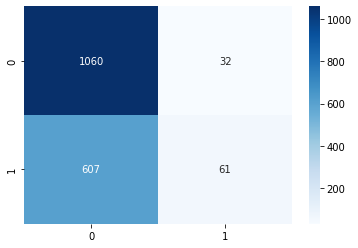

In [51]:
svc = SVC()
svc.fit(X_train, y_train)

model_metrics(svc, X_test, y_test)

In [53]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.6311
Test set score: 0.6369


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score: 0.48352272727272727
Report:               precision    recall  f1-score   support

           0       0.63      0.41      0.50      1092
           1       0.39      0.61      0.47       668

    accuracy                           0.48      1760
   macro avg       0.51      0.51      0.48      1760
weighted avg       0.54      0.48      0.49      1760



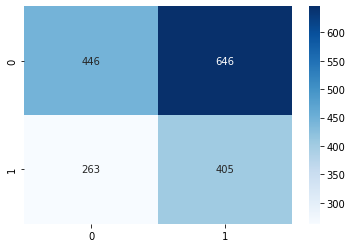

In [52]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

model_metrics(lr, X_test, y_test)

In [54]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(lr.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lr.score(X_test, y_test)))

Training set score: 0.4985
Test set score: 0.4835


Accuracy Score: 0.9238636363636363
Report:               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1092
           1       0.88      0.92      0.90       668

    accuracy                           0.92      1760
   macro avg       0.92      0.92      0.92      1760
weighted avg       0.92      0.92      0.92      1760



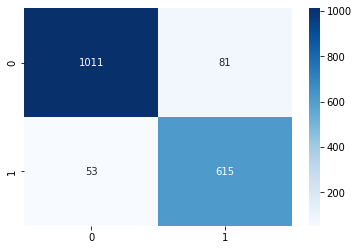

In [56]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

model_metrics(clf, X_test, y_test)

In [57]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9239


Accuracy Score: 0.9704545454545455
Report:               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1092
           1       0.95      0.97      0.96       668

    accuracy                           0.97      1760
   macro avg       0.97      0.97      0.97      1760
weighted avg       0.97      0.97      0.97      1760



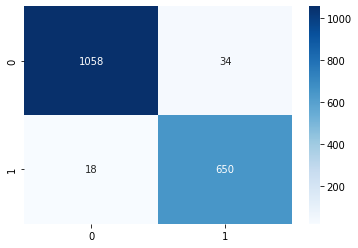

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

model_metrics(rf, X_test, y_test)

In [59]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(rf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9705


### Conclusions

This was an interesting experiement in the sense that trying to address outlier removal and perform feature selection on this dataset actually ended up making my models worse than without addressing these two topics. The models that assume normalizaiton, like LR and SVM, performed better when SMOTE was used on the whole dataset as it was versus addressing for outliers. Then models that do not assume normalization and don't usually need scaling/can do their own feature selction, ended up overfitting the training data. All in all, I believe the point is that if you start with bad data (in this case extremely uneven data) then you produce bad models. There is only so much you can do to account for poor data collection before you go back to data collection and see if there is a way to gain access to better or a more complete dataset. 